タイトル : 
気象庁データから翌日の天気を予測するkaggleぽいことをしてみた
tag :
python pandas sklearn kaggle 機械学習

こんにちは，Mt.Happyです．  
ただいま就活中でデータ分析系のお仕事を探しています．私に興味のある方は[Mt_Happy0506](https://twitter.com/Mt_Happy0506)までご連絡ください笑  
本題ですが，みなさん[kaggle](https://www.kaggle.com)ってご存知ですか?  
僕もあまり詳しくはないですが，データマイニングのモデルの精度を競うコンペサイトみたいですね．  
ちなみに僕自身は[タイタニックのコンペ](https://www.kaggle.com/c/titanic)には参加したことがあります(お察しください)  

今回のエントリーでは実際にkaggleをやるわけではないのですが，我々でも簡単に手に入るデータからkaggleっぽい遊びをやってみようというテーマでお送り致します．  

# 気象庁データから翌日の天気を予測する
このテーマでやってみようと思います．  
データは[気象庁のホームページ](http://www.data.jma.go.jp/gmd/risk/obsdl/)から入手しました．  
こちらのサイトでは，地点・項目・期間を任意に設定して気象に関するデータを獲得できます．  
今回は以下の設定でデータを入手しました．  

| 地点 | 項目 | 期間 |
|:--:|:--:|:--:|
| 東京 | 気温(平均・最高・最低), 降水量, 日照時間, 日射量, 風速(平均・最大・最大瞬間), 蒸気圧, <br>相対湿度, 気圧(現地・海面), 雲量, 天気概況(昼) | 2007~2017年における<br>9/31~10/31 |

予測する項目(目的変数)は天気概況(昼)で特徴量(説明変数)がそれ以外の項目にあたります．  
以上のデータは，先ほどのホームページからcsv形式でダウンロードできます．ここからこのcsvファイルを読み取り処理していくのですが，ダウンロードしたての生の状態では，ダウンロード時刻や品質番号，均質番号といった余分な項目が含まれているため，こういったものをあらかじめexcelを使って取り除きました．  
また翌日の天気を予測するタスクのため，日付と天気概況は一日分進めます．成形後は以下のイメージ．

|年月日|特徴量項目(気温etc...)|天気概況(昼：06時〜18時)|
|:--:|:--:|:--:|
|2007/10/1|hogehoge|曇時々雨|

それとcsvファイルは文字コードがshift-jisなのでutf-8に変更することもお忘れなく．(nkfとかツールで)  

## csvファイルを読み込もう
pandasを使ってcsvファイルを読み込みます．今回はindexとして日付型のデータを用いているのでindex及びparse_datesに'年月日'を指定しましょう．これで，indexがdatetime型で扱えます．  

In [1]:
import pandas as pd

df = pd.read_csv('data_tokyo.csv', index_col='年月日', parse_dates=['年月日'])

## 目的変数の成形
今回のデータでは目的変数である天気概況が詳細に記述されているので，おおざっぱに「晴・曇・雨」に分類します．  
データをよく眺めてみると，大雨や晴時々曇のように記述にはパターンがあり，接続詞的なものに「'後','一時','時々',' 、'」が使われていることがわかります．  

また修飾語がついている場合は，各トークンの最後の文字に注目するとそれが「晴・曇・雨」のいずれかの文字が使われています．  
よって正規表現や文字列のインデックスの指定で「晴・曇・雨」に分類できそうです．

In [2]:
import re
import datetime

#以降，目的変数はcolで指定します．
col = '天気概況(昼：06時〜18時)'

df[col] = df[col].apply(lambda x:re.split('[後|一時|時々|、]',x)[0][-1])

#分類できたか確認
df[col].value_counts()

晴    143
曇    141
雨     57
Name: 天気概況(昼：06時〜18時), dtype: int64

無事，「晴・曇・雨」に分類できました!

ついでに目的変数のラベルを整数に変換します．dataframeの型も忘れずに(これのせいで学習時にエラーが発生し問題解決に1時間とられました...)

In [3]:
#ラベルを整数に変換
df.loc[df[col]=='晴',col] = 0
df.loc[df[col]=='曇',col] = 1
df.loc[df[col]=='雨',col] = 2

#目的変数の型変換
df.loc[:,[col]]=df.loc[:,[col]].astype(int)

## データの分割
さて次に訓練データとテストデータを分割します．今回は，天気を予測するということで，2017年のデータを2007~2016年のデータに分割します．  
訓練データを2016年以前に，テストデータを2017年のものとします．(indexが日付型なのでこの作業は簡単)

In [4]:
traindf = df.loc[:'2016',:]
testdf = df.loc['2017':]

またそれぞれ説明変数と目的変数でも分割します．  

In [5]:
#dlist = [col,'最高気温(℃)','降水量の合計(mm)','平均湿度(％)','平均風速(m/s)','平均気温(℃)','最大風速(m/s)','合計全天日射量(MJ/u)']
dlist = [col]
X_train = traindf.loc[:'2016',:].drop(dlist,axis=1).values
y_train = traindf.loc[:'2016',col].values

X_test = testdf.loc['2017':,:].drop(dlist,axis=1).values
y_test = testdf.loc['2017':,col].values

## 特徴量の標準化
[ランダムフォレスト](https://ja.wikipedia.org/wiki/ランダムフォレスト)を使う場合だと，ほぼやる必要は無いですが，境界面を作っていくタイプのモデル(重回帰分析,ロジスティック回帰,SVMとか?)だとデータを標準化する方が予測精度が上がりやすい知見があるのでやります．(標準化についてはググればブログやwikiで解説があります)  
scikit-learnではこの標準化が以下のコードで簡単に行えます.  
ただしテストデータは未知データであるという前提があるため，標準化における平均と分散の計算には用いてはいけません．(重要)  

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#標準化させるために訓練データだけで平均と分散を計算
scaler.fit(X_train)
#訓練データ，テストデータを標準化する．
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

## とりあえず学習
では一旦，ここまでで獲得したデータからモデルを作成してみます．  
モデルはscikit-learnに標準装備されてるサポートベクターマシン(SVM)で行いました．  

In [7]:
from sklearn.svm import SVC

clf = SVC(class_weight='balanced',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## とりあえず評価
まぁ評価してみましょう．各ラベルの予測精度の平均はモデルのメソッドであるscoreで確認できます．  
またそれぞれの予測精度はscikit-learnのclassification_reportで確認できます．

In [8]:
from sklearn.metrics import classification_report

print('平均予測精度 : {}\n'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred,target_names=['晴','曇','雨']))

平均予測精度 : 0.3870967741935484

             precision    recall  f1-score   support

          晴       0.29      0.25      0.27         8
          曇       0.33      0.10      0.15        10
          雨       0.43      0.69      0.53        13

avg / total       0.36      0.39      0.34        31



めちゃくちゃ悪いですね笑 特に雨は全く予測できてません，，，  
当てずっぽで3分の1なんでそれより低いのは使い物になりません．

## 作戦変更...とりあえず晴れだけでも予測したい
上の通りです．というわけでラベルを以下のものに書き換えました．  

In [3]:
#ラベルを整数に変換
df.loc[df[col]=='晴',col] = 1
df.loc[df[col]=='曇',col] = 0
df.loc[df[col]=='雨',col] = 0

In [4]:
#目的変数の型変換
df.loc[:,[col]]=df.loc[:,[col]].astype(int)
traindf = df.loc[:'2016',:]
testdf = df.loc['2017':]
#dlist = [col,'最高気温(℃)','降水量の合計(mm)','平均湿度(％)','平均風速(m/s)','平均気温(℃)','最大風速(m/s)','合計全天日射量(MJ/u)']
dlist = [col]
X_train = traindf.loc[:'2016',:].drop(dlist,axis=1).values
y_train = traindf.loc[:'2016',col].values

X_test = testdf.loc['2017':,:].drop(dlist,axis=1).values
y_test = testdf.loc['2017':,col].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#標準化させるために訓練データだけで平均と分散を計算
scaler.fit(X_train)
#訓練データ，テストデータを標準化する．
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report

print('平均予測精度 : {}\n'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred,target_names=['曇or雨','晴']))

X_train = traindf.loc[:'2016',:].drop(dlist,axis=1).values
y_train = traindf.loc[:'2016',col].values

X_test = testdf.loc['2017':,:].drop(dlist,axis=1).values
y_test = testdf.loc['2017':,col].values
print(clf)

平均予測精度 : 0.7096774193548387

             precision    recall  f1-score   support

       曇or雨       0.77      0.87      0.82        23
          晴       0.40      0.25      0.31         8

avg / total       0.67      0.71      0.69        31

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


少しまともに見えますね笑

## パラメータチュニーングする
### パラメータについて
モデルを構築する際のキモになるところです．  
今回利用する学習モデルのSVMには，境界面の複雑さを制御するパラメータとして$C$と$\alpha$があります．  
僕のイメージでは，Cとgammaが高いほどoverfittingする感じです．([こちらのサイト](https://qiita.com/sz_dr/items/f3d6630137b184156a67)でわかりやすく解説)  
またそれぞれのクラスのサンプル数に偏りがあるデータ(不均衡なデータ)の場合，片方の分類精度が極端に悪くなってしまう場合があります．(参考:[unbalanced-problems](http://scikit-learn.org/0.18/modules/svm.html#unbalanced-problems))  

そこで各クラスでバランス良く重み付けしてくれるclass_weight='balanced'を設定するか否かという点についてもチューニングして判断します．  
### 時系列データにおける交差検証の注意点
交差検証についての説明は割愛しますが，今回の場合は一般的なランダム抽出の交差検証ではなく，各年度ごとにグループを作成して行います．  
このアプローチをとった理由は，時系列データは自己相似性があり，indexの近いデータ同士は類似しやすい特性があるためです．  
したがって，ある年度のデータをその他の年度のデータを用いて予測するということを繰り返し，パラメータのチュニーングを行なっていく必要があります．  
scikit-learnではこのための交差検証のクラスにGroupKFoldがあります．これによって作成した分割のリストをGridSearchCVの引数cvに投げることで前述した交差検証が行えます．  

### 標準化と学習のパイプライン化
標準化の項目でも説明したようにテストデータは平均と分散の計算に用いていけないという掟があります．  
交差検証も同様で検証データ(validation data)は別に平均と分散を計算しなければなりません．  
これをscikit-learnのグリッドサーチで実現するために，標準化と学習をパイプライン化します．  
この関数もscikit-learnに標準装備されており，そのまんまPipelineクラスで行えます．  
scikit-learnは本当に便利ですよね〜笑  

In [14]:
# group 10-fold cross validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GroupKFold

n = X_train.shape[1]

#標準化と学習のパイプライン
pipe = Pipeline([('scaler',StandardScaler()),("svm",SVC(random_state=0))])
pipe.fit(X_train,y_train)

#パラメータは10^nオーダーで変化させる
params = {'svm__C':[0.0001,0.001,0.01,0.1,1,10,100],'svm__gamma':[1/n,0.001,0.01,0.1,1,10,100],'svm__class_weight':[None,'balanced']}
#年度は31indexごとに切り替わるため
groups = sum([[label]*31 for label in range(10)],[])
gkfold = list(GroupKFold(n_splits=10).split(X_train,y_train,groups))

#グリッドサーチ
grid = GridSearchCV(pipe, param_grid = params, cv = gkfold, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

print('Best cross-validation accuracy: {:.2f}'.format(grid.best_score_))
print('Train set score: {:.2f}'.format(grid.score(X_train,y_train)))
print('Best parameters : {}'.format(grid.best_params_))

/home/fukuyama/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/fukuyama/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best cross-validation accuracy: 0.65
Train set score: 0.67
Best parameters : {'svm__class_weight': 'balanced', 'svm__gamma': 0.01, 'svm__C': 1}


それでは，チューニングしたパラメータでテストデータを確認しましょう．

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.svm import SVC


clf = SVC(C=1.0, gamma=0.01, random_state=0, probability=True, class_weight='balanced')
clf.fit(X_train, y_train)

print('平均予測精度 : {}\n'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred,target_names=['曇or雨','晴']))

平均予測精度 : 0.6129032258064516

             precision    recall  f1-score   support

       曇or雨       0.77      0.87      0.82        23
          晴       0.40      0.25      0.31         8

avg / total       0.67      0.71      0.69        31



チューニング前より下がってる，，，ナンテコッタ

# 悲しみを乗り越えて...

というわけで，まさかのチューニングしない方がよかったという結果になってしまいました笑  
色々理由は考えられるのですが，今年のデータはこれまでに無い異常気象だったということでなんでしょうかね  

今回のエントリーはここでおしまいですが，引き続き特徴量選択やらベースラインを作ってみたことについても記事にするので，  
興味がある方は是非ご拝読くださいませ  

それではまた次回!

In [5]:
import numpy as np
groups = np.array(sum([[label]*31 for label in range(10)],[]))

X_train[np.where(groups==0)],y_train[np.where(groups==0)]

X_train.shape

(310, 14)

In [6]:
y_train.reshape(-1,1)

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [7]:
X_train

array([[ 16.8 ,  18.7 ,  15.7 , ...,   7.1 ,  13.2 ,   2.  ],
       [ 18.1 ,  19.9 ,  16.4 , ...,   4.9 ,   8.4 ,   3.8 ],
       [ 19.8 ,  22.7 ,  17.2 , ...,   5.1 ,   7.6 ,   7.2 ],
       ..., 
       [ 12.2 ,  14.8 ,  10.1 , ...,   4.9 ,   7.6 ,   1.46],
       [ 15.5 ,  20.8 ,  11.6 , ...,   5.8 ,  13.6 ,   4.33],
       [ 11.9 ,  13.5 ,   9.6 , ...,   4.7 ,   8.  ,   3.93]])

In [8]:
import tensorflow as tf
import random
import numpy as np

random.seed(0)

x = tf.placeholder(tf.float32, shape=(None, 14), name="x")
y_ = tf.placeholder(tf.float32, shape=(None, 1), name="y")

W = tf.Variable(tf.zeros((14, 1),tf.float32), name="W")
b = tf.Variable(.0, name="b")

u = tf.matmul(x, W) + b
y = tf.sigmoid(u)

#tf.get_variable_scope().reuse_variables()

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = u, logits = y_)
loss = tf.reduce_mean(cross_entropy)

opt = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

sess = tf.Session()
init = tf.initialize_all_variables()

#TensorBoardで追跡する変数を定義
#with tf.name_scope('summary'):
tf.summary.scalar('loss', loss)
writer = tf.summary.FileWriter('./logs', sess.graph)

merged = tf.summary.merge_all()

sess.run(init)

y_tra = y_train.reshape(-1,1)

for i in range(200000):
    
    idx = random.randint(0, 9)
    batch_xs, batch_ys = X_train[np.where(groups==idx)].astype(np.float32),y_train[np.where(groups==idx)].reshape(-1,1)
    opt_, l, W_ = sess.run([opt, loss, W], feed_dict={x: batch_xs, y_:batch_ys})
    if (i + 1) % 100 == 0:
        print("step=%3d, loss=%.2f" % (i + 1, l))
        print(X_train.shape,y_train.reshape(-1,1).shape)
        loss_val,foo = sess.run([loss,merged], feed_dict={x: X_train, y_: y_train.reshape(-1,1)})
        writer.add_summary(foo,i)
        
est_a, est_b = sess.run([W, b], feed_dict={x: X_test, y_: y_test.reshape(-1,1)})
print("Estimated: a1=%6.2f, a2=%6.2f, b=%6.2f" % (est_a[0], est_a[1], est_b))   

new_y = sess.run(y, feed_dict={x: X_test})
print(new_y)

sess.close()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step=100, loss=-5241349.00
(310, 14) (310, 1)
step=200, loss=-10831141.00
(310, 14) (310, 1)
step=300, loss=-5142867.50
(310, 14) (310, 1)
step=400, loss=-16198750.00
(310, 14) (310, 1)
step=500, loss=-15827746.00
(310, 14) (310, 1)
step=600, loss=-24247700.00
(310, 14) (310, 1)
step=700, loss=-36476628.00
(310, 14) (310, 1)
step=800, loss=-25446052.00
(310, 14) (310, 1)
step=900, loss=-49377468.00
(310, 14) (310, 1)
step=1000, loss=-40497768.00
(310, 14) (310, 1)
step=1100, loss=-31846598.00
(310, 14) (310, 1)
step=1200, loss=-48733388.00
(310, 14) (310, 1)
step=1300, loss=-67897728.00
(310, 14) (310, 1)
step=1400, loss=-57029236.00
(310, 14) (310, 1)
step=1500, loss=-78610912.00
(310, 14) (310, 1)
step=1600, loss=-83808632.00
(310, 14) (310, 1)
step=1700, loss=-89284496.00
(310, 14) (310, 1)
step=1800, loss=-73704816.00
(310, 14) (310, 1)
step=1900, loss=-72096672.00
(310, 14) (310, 1)
step=2000, loss=-11047222

step=16300, loss=-659908928.00
(310, 14) (310, 1)
step=16400, loss=-615558784.00
(310, 14) (310, 1)
step=16500, loss=-285372800.00
(310, 14) (310, 1)
step=16600, loss=-908847040.00
(310, 14) (310, 1)
step=16700, loss=-914416384.00
(310, 14) (310, 1)
step=16800, loss=-486499104.00
(310, 14) (310, 1)
step=16900, loss=-925520768.00
(310, 14) (310, 1)
step=17000, loss=-492419744.00
(310, 14) (310, 1)
step=17100, loss=-541477568.00
(310, 14) (310, 1)
step=17200, loss=-544821760.00
(310, 14) (310, 1)
step=17300, loss=-501118112.00
(310, 14) (310, 1)
step=17400, loss=-705152512.00
(310, 14) (310, 1)
step=17500, loss=-302909408.00
(310, 14) (310, 1)
step=17600, loss=-509906144.00
(310, 14) (310, 1)
step=17700, loss=-969639296.00
(310, 14) (310, 1)
step=17800, loss=-870674496.00
(310, 14) (310, 1)
step=17900, loss=-672619648.00
(310, 14) (310, 1)
step=18000, loss=-986356928.00
(310, 14) (310, 1)
step=18100, loss=-733381120.00
(310, 14) (310, 1)
step=18200, loss=-527246944.00
(310, 14) (310, 1)


step=32900, loss=-1043600768.00
(310, 14) (310, 1)
step=33000, loss=-1241682048.00
(310, 14) (310, 1)
step=33100, loss=-1343082624.00
(310, 14) (310, 1)
step=33200, loss=-1347307904.00
(310, 14) (310, 1)
step=33300, loss=-1252888704.00
(310, 14) (310, 1)
step=33400, loss=-1635544192.00
(310, 14) (310, 1)
step=33500, loss=-971949120.00
(310, 14) (310, 1)
step=33600, loss=-1264140032.00
(310, 14) (310, 1)
step=33700, loss=-1367724672.00
(310, 14) (310, 1)
step=33800, loss=-1759382912.00
(310, 14) (310, 1)
step=33900, loss=-1859922304.00
(310, 14) (310, 1)
step=34000, loss=-1865409792.00
(310, 14) (310, 1)
step=34100, loss=-1283377280.00
(310, 14) (310, 1)
step=34200, loss=-1780137984.00
(310, 14) (310, 1)
step=34300, loss=-1882071552.00
(310, 14) (310, 1)
step=34400, loss=-1294670592.00
(310, 14) (310, 1)
step=34500, loss=-1400660736.00
(310, 14) (310, 1)
step=34600, loss=-1899044352.00
(310, 14) (310, 1)
step=34700, loss=-1408540928.00
(310, 14) (310, 1)
step=34800, loss=-603436224.00
(

step=49400, loss=-1859190528.00
(310, 14) (310, 1)
step=49500, loss=-1863056896.00
(310, 14) (310, 1)
step=49600, loss=-2722102272.00
(310, 14) (310, 1)
step=49700, loss=-2017595008.00
(310, 14) (310, 1)
step=49800, loss=-1874165376.00
(310, 14) (310, 1)
step=49900, loss=-2026052608.00
(310, 14) (310, 1)
step=50000, loss=-2744231424.00
(310, 14) (310, 1)
step=50100, loss=-2033708928.00
(310, 14) (310, 1)
step=50200, loss=-2038072832.00
(310, 14) (310, 1)
step=50300, loss=-1596241024.00
(310, 14) (310, 1)
step=50400, loss=-873977152.00
(310, 14) (310, 1)
step=50500, loss=-1602462848.00
(310, 14) (310, 1)
step=50600, loss=-1605815936.00
(310, 14) (310, 1)
step=50700, loss=-879262016.00
(310, 14) (310, 1)
step=50800, loss=-1474552832.00
(310, 14) (310, 1)
step=50900, loss=-2650242304.00
(310, 14) (310, 1)
step=51000, loss=-2498787072.00
(310, 14) (310, 1)
step=51100, loss=-886241984.00
(310, 14) (310, 1)
step=51200, loss=-2078823296.00
(310, 14) (310, 1)
step=51300, loss=-2082708480.00
(3

step=65600, loss=-3214678272.00
(310, 14) (310, 1)
step=65700, loss=-3219640832.00
(310, 14) (310, 1)
step=65800, loss=-1141250688.00
(310, 14) (310, 1)
step=65900, loss=-2091679232.00
(310, 14) (310, 1)
step=66000, loss=-3623249920.00
(310, 14) (310, 1)
step=66100, loss=-1918794496.00
(310, 14) (310, 1)
step=66200, loss=-1921681152.00
(310, 14) (310, 1)
step=66300, loss=-3248822528.00
(310, 14) (310, 1)
step=66400, loss=-2107542272.00
(310, 14) (310, 1)
step=66500, loss=-2503311104.00
(310, 14) (310, 1)
step=66600, loss=-2507756032.00
(310, 14) (310, 1)
step=66700, loss=-2708594944.00
(310, 14) (310, 1)
step=66800, loss=-2514649856.00
(310, 14) (310, 1)
step=66900, loss=-2123446528.00
(310, 14) (310, 1)
step=67000, loss=-2126523392.00
(310, 14) (310, 1)
step=67100, loss=-1163713664.00
(310, 14) (310, 1)
step=67200, loss=-2728203008.00
(310, 14) (310, 1)
step=67300, loss=-3297685248.00
(310, 14) (310, 1)
step=67400, loss=-1956300288.00
(310, 14) (310, 1)
step=67500, loss=-2740114176.00

step=81700, loss=-4253318912.00
(310, 14) (310, 1)
step=81800, loss=-3079108864.00
(310, 14) (310, 1)
step=81900, loss=-4494593024.00
(310, 14) (310, 1)
step=82000, loss=-3328322304.00
(310, 14) (310, 1)
step=82100, loss=-2605190144.00
(310, 14) (310, 1)
step=82200, loss=-3336327936.00
(310, 14) (310, 1)
step=82300, loss=-3097002752.00
(310, 14) (310, 1)
step=82400, loss=-2614540032.00
(310, 14) (310, 1)
step=82500, loss=-3104457472.00
(310, 14) (310, 1)
step=82600, loss=-1432072576.00
(310, 14) (310, 1)
step=82700, loss=-3112696320.00
(310, 14) (310, 1)
step=82800, loss=-4056082944.00
(310, 14) (310, 1)
step=82900, loss=-3120135424.00
(310, 14) (310, 1)
step=83000, loss=-2408463104.00
(310, 14) (310, 1)
step=83100, loss=-4560274432.00
(310, 14) (310, 1)
step=83200, loss=-3131634432.00
(310, 14) (310, 1)
step=83300, loss=-4336550400.00
(310, 14) (310, 1)
step=83400, loss=-4576725504.00
(310, 14) (310, 1)
step=83500, loss=-4346745856.00
(310, 14) (310, 1)
step=83600, loss=-4587955200.00

step=97800, loss=-1696432896.00
(310, 14) (310, 1)
step=97900, loss=-3686692864.00
(310, 14) (310, 1)
step=98000, loss=-1699975552.00
(310, 14) (310, 1)
step=98100, loss=-5386233344.00
(310, 14) (310, 1)
step=98200, loss=-5391733248.00
(310, 14) (310, 1)
step=98300, loss=-5119825408.00
(310, 14) (310, 1)
step=98400, loss=-5124865536.00
(310, 14) (310, 1)
step=98500, loss=-3709297664.00
(310, 14) (310, 1)
step=98600, loss=-3130167040.00
(310, 14) (310, 1)
step=98700, loss=-4008613120.00
(310, 14) (310, 1)
step=98800, loss=-4012062464.00
(310, 14) (310, 1)
step=98900, loss=-3723672832.00
(310, 14) (310, 1)
step=99000, loss=-2874457600.00
(310, 14) (310, 1)
step=99100, loss=-5161757696.00
(310, 14) (310, 1)
step=99200, loss=-5447015936.00
(310, 14) (310, 1)
step=99300, loss=-4032519168.00
(310, 14) (310, 1)
step=99400, loss=-2886059008.00
(310, 14) (310, 1)
step=99500, loss=-4041290240.00
(310, 14) (310, 1)
step=99600, loss=-3162045440.00
(310, 14) (310, 1)
step=99700, loss=-2894754048.00

In [18]:
batch_xs.shape,batch_ys.shape

((31, 14), (31, 1))

In [177]:
pred = new_y.T[0] > 0.5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(confusion_matrix(y_test, pred), accuracy_score(y_test, pred))

[[10 13]
 [ 4  4]] 0.451612903226


In [19]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000,random_state=0,max_depth=2,max_features=3)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [21]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

fp = font_manager.FontProperties(fname="/home/fukuyama/IPAfont00303/ipag.ttf",size=20)

print("{:.3f}".format(clf.score(X_train,y_train)))
print("{:.3f}".format(clf.score(X_test,y_test)))

print("{}".format(clf.feature_importances_))

n_featrures = X_train.shape[1]

plt.figure(figsize=(10, 10))
n_features = len(traindf.drop(dlist,axis=1).columns)
plt.barh(range(n_featrures),clf.feature_importances_,align='center')
plt.yticks(np.arange(n_features),traindf.drop(dlist,axis=1).columns,fontproperties=fp)
plt.xlabel("Feature importance")

0.694
0.645
[ 0.0346702   0.02555176  0.07519289  0.0291062   0.0358884   0.03466751
  0.11215814  0.07157213  0.11955964  0.09250014  0.16021424  0.05785689
  0.09030374  0.06075811]


In [22]:
# k-fold cross validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GroupKFold

pipe = Pipeline([('scaler',StandardScaler()),("svm",SVC(random_state=0))])
pipe.fit(X_train,y_train)

params = {'svm__C':[0.0001,0.001,0.01,0.1,1,10,100],'svm__gamma':[0.001,0.01,0.1,1,10,100],'svm__class_weight':[None,'balanced']}
groups = sum([[label]*31 for label in range(10)],[])
gkfold = list(GroupKFold(n_splits=10).split(X_train,y_train,groups))

grid = GridSearchCV(pipe, param_grid = params, cv = gkfold, scoring='accuracy',n_jobs=-1)
grid.fit(X_train,y_train)

print('Best cross-validation accuracy: {:.2f}'.format(grid.best_score_))
print('Test set score: {:.2f}'.format(grid.score(X_train,y_train)))
print('Best parameters : {}'.format(grid.best_params_))

Best cross-validation accuracy: 0.65
Test set score: 0.67
Best parameters : {'svm__class_weight': 'balanced', 'svm__gamma': 0.01, 'svm__C': 1}


In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [24]:
from sklearn.svm import SVC

clf = SVC(C=10.0, gamma=0.01, random_state=0, probability=True, class_weight=None)
clf.fit(X_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [25]:
pred = clf.predict(X_test)
clf

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [26]:
clf.score(X_test, y_test)

0.64516129032258063

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred,target_names=['曇or雨','晴']))

             precision    recall  f1-score   support

       曇or雨       0.75      0.78      0.77        23
          晴       0.29      0.25      0.27         8

avg / total       0.63      0.65      0.64        31



Confusion matrix, without normalization
[[18  5]
 [ 6  2]]


/home/fukuyama/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['ipag'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.75  0.25]]


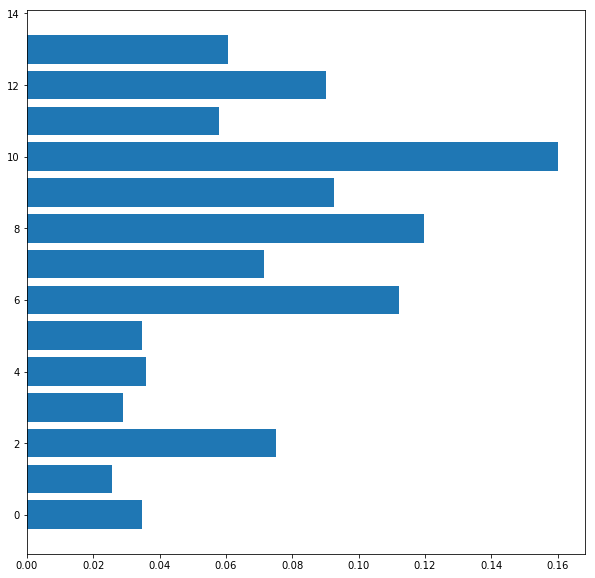

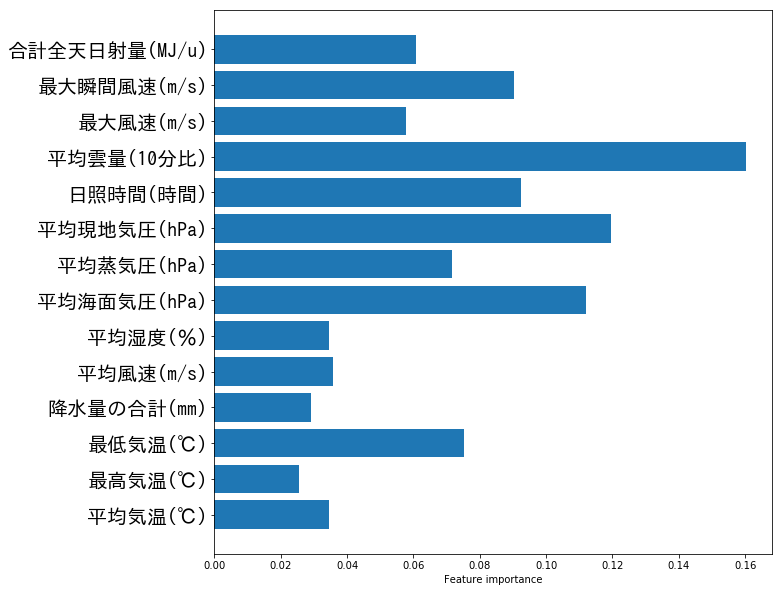

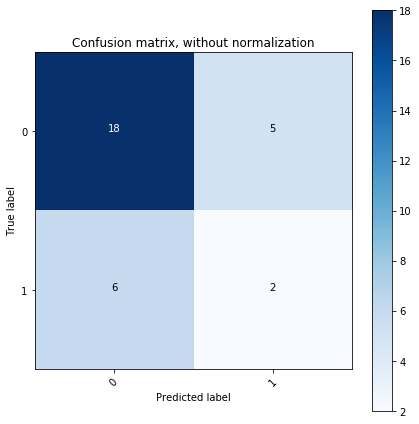

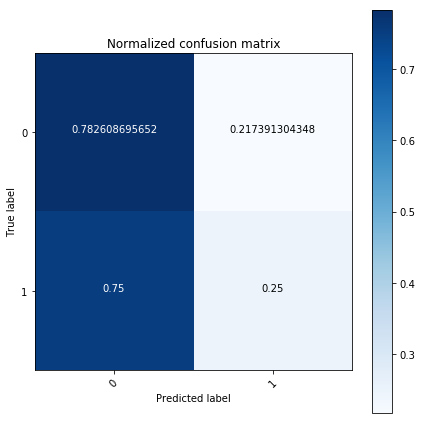

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(2)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(2)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
idx = [d.strftime('%Y/%m/%d') for d in traindf[col].index.tolist()]
weather = traindf[col].values.tolist()

wd = {i:w for i,w in zip(idx,weather)}

In [30]:
from collections import defaultdict

baysedict = defaultdict(int)

for today,w in wd.items():
    ystday = (datetime.datetime.strptime(today, '%Y/%m/%d') - datetime.timedelta(days=1)).strftime('%Y/%m/%d')
    
    if ystday in wd.keys():
        baysedict[(wd[ystday],wd[today])] += 1
        

SUM = sum(baysedict.values())

In [31]:
baysedict,round(66/(103+66),4),round(68/(63+68),4),round((66+68)/(103+66+63+68),4)

(defaultdict(int, {(0, 0): 103, (0, 1): 66, (1, 0): 63, (1, 1): 68}),
 0.3905,
 0.5191,
 0.4467)

In [32]:
import datetime

def naivebayse(df):
    
    plist = []
    
    col = '天気概況(昼：06時〜18時)'
    
    idx = [d.strftime('%Y/%m/%d') for d in df[col].index.tolist()]
    weather = df[col].values.tolist()
    wd = {i:w for i,w in zip(idx,weather)}
    
    for today,w in wd.items():
        ystday = (datetime.datetime.strptime(today, '%Y/%m/%d') - datetime.timedelta(days=1)).strftime('%Y/%m/%d')
    
        if ystday in wd.keys():
            if   wd[ystday] == 0:
                plist.append(0.3905)
            elif wd[ystday] == 1:
                plist.append(0.5191)
        else:
            plist.append(0.4467)
    return plist

nb = naivebayse(testdf)

In [33]:
from sklearn.metrics import log_loss

log_loss(y_test,clf.predict_proba(X_test)),log_loss(y_test,[0.4355 for i in range(31)]),log_loss(y_test,nb)

(0.65957403074804466, 0.63876859534007435, 0.60697667020555324)

学習のさせ方 : 
過去30日のデータをvalidation dataとして訓練する．
